# **Assignment 4 ROB313 - Neural Networks**

In [64]:
# Import relevant libraries
import autograd.numpy as np
from autograd.scipy.special import logsumexp
import autograd.numpy.random as npr
from autograd import grad
from autograd.misc.optimizers import adam
import os
import sys
import matplotlib.pyplot as plt
from data.data_utils import load_dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [65]:
# Dictionary to store train/val history
global opt_history

opt_history = {
    "train_nll": [],
    "val_nll": [],
    "train_loss": [],
    "val_loss": [],
    "predictions": None
}

In [66]:
# Neuron Initialization and Activations

def init_randn(m, n, rs=npr.RandomState(0)):
    """ init mxn matrix using small random normal"""
    return 0.1 * rs.randn(m, n)

def init_xavier(m, n, rs=npr.RandomState(0)):
    """Init mxn matrix using Xavier intialization - initialization of weights"""
    return rs.randn(m,n)/np.sqrt(n)

def init_net_params(layer_sizes, init_fcn, rs=npr.RandomState(0)):
    """ inits a (weights, biases) tuples for all layers using the intialize function (init_fcn).
        W contains weights for each of the feature functions, hence being an MxN matrix"""
    return [
        (init_fcn(m, n), np.zeros(n))  # weight matrix  # bias vector
        for m, n in zip(layer_sizes[:-1], layer_sizes[1:])
    ]

def relu(x):
    return np.maximum(0, x)

In [67]:
# Neural network training and prediction

def neural_net_predict(params, inputs):
    """Implements a deep neural network for classification.
       params is a list of (weights, bias) tuples.
       inputs is an (N x D) matrix.
       returns normalized class log-probabilities."""
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = relu(outputs)
    return outputs - logsumexp(outputs, axis=1, keepdims=True)

def mean_log_like(params, inputs, targets):
    """return the log-likelihood / the number of inputs """
    return np.sum((targets*neural_net_predict(params, inputs)))/len(inputs)

def accuracy(params, inputs, targets, valid):
    """ return the accuracy of the neural network defined by params"""
    target_class = np.argmax(targets, axis=1)
    predicted_class = np.argmax(neural_net_predict(params, inputs), axis=1)
    if valid:
        opt_history["predictions"] = predicted_class
    return np.mean(predicted_class == target_class)

def getConfusionMatrix(predictions, targets):
    '''Create confusion matrix for validation predictions and plot results'''
    cm = confusion_matrix(targets, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

     Epoch     |    Train accuracy  |    Validation accuracy  |       Test accuracy  
              0|              0.1076|                    0.096|               0.111
              1|              0.9204|                    0.905|               0.931
              2|              0.9548|                    0.926|               0.949
              3|              0.9736|                     0.94|               0.948
              4|              0.9798|                    0.943|               0.954
              5|              0.9879|                    0.946|               0.956
              6|              0.9918|                    0.945|                0.96
              7|              0.9918|                    0.953|               0.958
              8|              0.9933|                    0.945|               0.962
              9|              0.9885|                    0.941|               0.957
             10|              0.9942|                    0.946|           

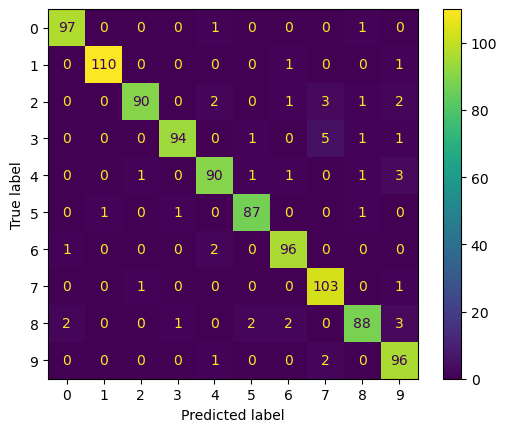

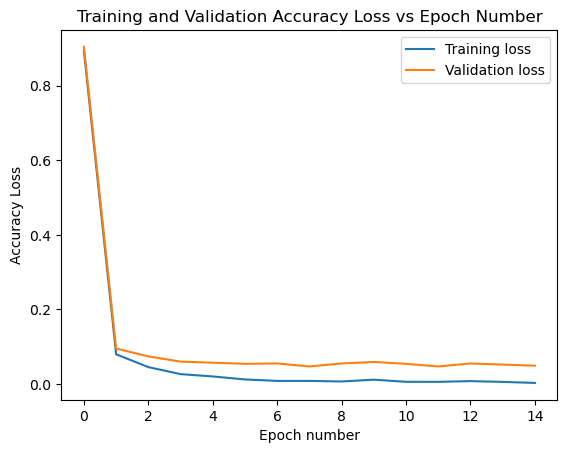

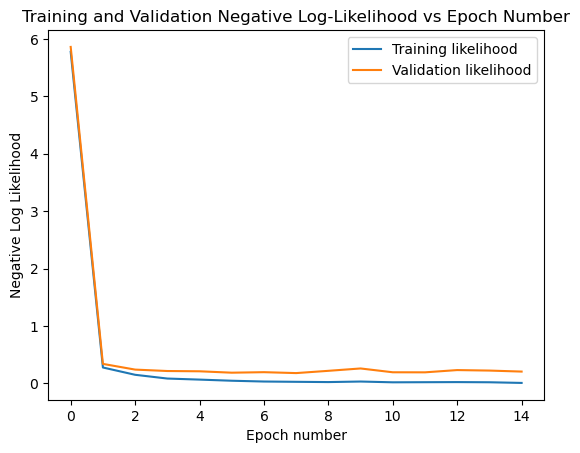

In [68]:
if __name__ == "__main__":
    # loading data
    x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset("mnist_small")

    # initializing parameters
    # 784 - dealing with 28x28 image as input, ___ hidden layers, 10 output nodes for classifying digits 0-9
    layer_sizes = [784, 600, 10]
    params = init_net_params(layer_sizes, init_randn)

    # setting up training parameters
    num_epochs = 15
    learning_rate = 1e-2
    batch_size = 256

    # Constants for batching
    num_batches = int(np.ceil(len(x_train) / batch_size))
    rind = np.arange(len(x_train))
    npr.shuffle(rind)

    def batch_indices(iter):
        idx = iter % num_batches
        return rind[slice(idx * batch_size, (idx + 1) * batch_size)]

    # Define training objective
    def objective(params, iter):
        # get indices of data in batch
        idx = batch_indices(iter)
        return -mean_log_like(params, x_train[idx], y_train[idx])

    # Get gradient of objective using autograd.
    objective_grad = grad(objective)

    print("     Epoch     |    Train accuracy  |    Validation accuracy  |       Test accuracy  ")
    
    def callback(params, iter, gradient):
        if iter % num_batches == 0:
            # record training & val. accuracy every epoch
            opt_history["train_nll"].append(-mean_log_like(params, x_train, y_train))
            opt_history["val_nll"].append(-mean_log_like(params, x_valid, y_valid))
            train_acc = accuracy(params, x_train, y_train, valid=False)
            val_acc = accuracy(params, x_valid, y_valid, valid=True)
            test_acc = accuracy(params, x_test, y_test, valid=False)
            print("{:15}|{:20}|{:25}|{:20}".format(iter // num_batches, train_acc, val_acc, test_acc))
            train_loss = np.full((train_acc.shape), 1) - train_acc
            val_loss = np.full((val_acc.shape), 1) - val_acc
            opt_history["train_loss"].append(train_loss)
            opt_history["val_loss"].append(val_loss)
            
    # We will optimize using Adam (a variant of SGD that makes better use of
    # gradient information).
    opt_params = adam(
        objective_grad,
        params,
        step_size=learning_rate,
        num_iters=num_epochs * num_batches,
        callback=callback,
    )

    # Use final params of trained model to create confusion matrix
    target = np.argmax(y_valid, axis=1)
    getConfusionMatrix(opt_history["predictions"], target)

    # Plotting training and validation loss vs epoch count
    plt.plot(opt_history["train_loss"], label='Training loss')
    plt.plot(opt_history["val_loss"], label='Validation loss')
    plt.title('Training and Validation Accuracy Loss vs Epoch Number')
    plt.xlabel('Epoch number')
    plt.ylabel('Accuracy Loss')
    plt.legend(loc=0)
    plt.show()

    # Plotting the train and validation negative log-likelihood
    plt.plot(opt_history["train_nll"], label='Training likelihood')
    plt.plot(opt_history["val_nll"], label='Validation likelihood')
    plt.title('Training and Validation Negative Log-Likelihood vs Epoch Number')
    plt.xlabel('Epoch number')
    plt.ylabel('Negative Log Likelihood')
    plt.legend(loc=0)
    plt.show()

**Question 1**
- Epsilon, the variance of the linear activation function must be equal to 1/sqrt(D^2)
- In this case, D is the number of inputs to a neuron

**Question 2**
- The logsumexp function from scipy computes the log of the sum of exponentials of input elements for us. We have used the logsumexp function instead of a more naive approach (manual computation) to get the predicted log probabilities for each class because it does this computation in a more stable way. This function can help us prevent underflow/overflow errors, which is one issue that we experienced within assignment 3 when working with log likelihoods. This is often called the logsumexp trick, which deals with the possibility of the log sum blowing up during multi-class classification. For instance, the naive approach could crash in multiple instances due to division by 0 or when dealing with inf/nan values, thus causing numerical instability. Overall, the logsumexp function prevents this issue from occuring, therefore making our program more robust.

**Question 4**
- Increasing the number of hidden layers does help with accuracy, but as we get too high (i.e. 1000) our accuracy does not seem to improve. This is likely why its better to compliment increasing the number of hidden layers with an appropriate learning rate, otherwise additional computations are done without reason.
- When decreasing learning rate, need to increase epoch number, otherwise will not converge to accurate enough model compared to using a larger learning rate with the same epoch number

**Question 5**
- Confusion matrix analyzes the potential of the classifier model; it gives you a better idea of the types of errors the model is making during the classification process
- All diagonal elements denote correctly classified outcomes
- Misclassified outcomes are represented on the off diagonals of the confusion matrix
- This means that the best classifier will have a confusion matrix with only diagonal elements and the rest of the elements set to 0
- In our confusion matrix, we see that we confuse the true label of '3' with '7' the most in the MNIST dataset, with a total of 5 mistakes. Aside from this, we see that we most oftenly mistake other numbers such as '4' and '8' with '9' as our prediction of 9 has the most inaccurate classifications of the digits available to classify with. This means that to further improve the model, we should provide more data on the numbers '7' and '9' as we see that the model misclassifies with them more than the others. Moreover, more data on the number '3' and number '8' would be useful to generate a more accurate model that does not confuse handwritten variations of those numbers with '7' and '9', as previously mentioned.
- The confusion matrix can also be used to optimize the model for precision. When optimizing for precision, we are attempting to reduce the variance of false classifications among the digits the model can decide upon. Essentially, we want to improve the model such that if it does make false classifications, those false classifications are all of the same digit, rather than having a spread of false classifications among many digits in the set. This will allow us to further narrow down on which digits require more data to remove the confusion in the model's performance. 
